# LPC with ANS

This notebook covers evaluation of Linear Predicitve Coding with Asymmetric Numeral Systems using the compression-evaluation package.

The Predictive Coder and Decoder evaluated in this notebook follows the following structure,

![Encoder](images/PC_processing-Encoder-Point-Predictor.drawio.png)


![Decoder](images/PC_processing-Decoder-Point-Predictor.drawio.png)

Before executing the code below, following pre-requisites (in addition to the ones required for the evaluator package) are required.

In [27]:
%pip install pandas matplotlib numpy scikit-learn
%pip install ../dist/compression_evaluation-0.1.0-py3-none-any.whl --force-reinstall

Note: you may need to restart the kernel to use updated packages.
Processing c:\users\atlee\pycharmprojects\compression-eval\dist\compression_evaluation-0.1.0-py3-none-any.whl
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
  Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached psutil-7.1.0-cp37-abi3-win_amd64.whl.metadata (23 kB)
Using cached memory_profiler-0.61.0-py3-none-any.whl (31 kB)
Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl (12.8 MB)
Using cached psutil-7.1.0-cp37-abi3-win_amd64.whl (247 kB)

  Attempting uninstall: psutil

    Found existing installation: psutil 7.1.0

    Uninstalling psutil-7.1.0:

      Successfully uninstalled psutil-7.1.0

   ---------------------------------------- 0/4 [psutil]
   ---------------------------------------- 0/4 [psutil]
   ---------------------------------------- 0/4 [psutil]
  Attempting uninstall: numpy
   ---------------------------------------- 0/4 [psutil]
    Found existin

  You can safely remove it manually.
  You can safely remove it manually.


## Import datasets

Three datasets were used in this evaluation, all extracted from the Ariviyal Nagar weather station. Datasets accessible [here](https://www.ariviyalnagarweatherstation.org/Data.html).

From the dataset, three columns were used for this evaluation, which were extracted and isolated into seperate files for convenience. They were,
1. Solar Radition - A dataseries with a multi-modal (bimodal) distribution
2. Water Content - A dataseries with sudden rises and falls with mostly gradual fade
3. Air Temperature - A dataseries with mostly deterministic patterns with slight noise

In [28]:
import pandas as pd

water_content_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Water_Content.csv')
solar_radiation_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Solar_Radiation.csv')
air_temperature_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Air_Temperature.csv')

extract dataseries,

In [29]:
water_content_column = water_content_df['Water Content']
solar_radiation_column = solar_radiation_df['Solar Radiation']
air_temperature_column = air_temperature_df['Air Temperature']

## Inspect datasets

Basic data pre-processing

In [30]:
def print_invalids_count():
    print("Water Content NaNs:", water_content_column.isna().sum())
    print("Solar Radiation NaNs:", solar_radiation_column.isna().sum())
    print("Air Temperature NaNs:", air_temperature_column.isna().sum())

    print("Water Content Nulls:", water_content_column.isnull().sum())
    print("Solar Radiation Nulls:", solar_radiation_column.isnull().sum())
    print("Air Temperature Nulls:", air_temperature_column.isnull().sum())

def fill_with_mean(series):
    # Find indices where value is NaN or null
    nan_indices = series[series.isna() | series.isnull()].index
    for idx in nan_indices:
        prev_idx = idx - 1
        next_idx = idx + 1
        # Find previous non-null value
        while prev_idx >= 0 and (pd.isna(series.iloc[prev_idx]) or pd.isnull(series.iloc[prev_idx])):
            prev_idx -= 1
        # Find next non-null value
        while next_idx < len(series) and (pd.isna(series.iloc[next_idx]) or pd.isnull(series.iloc[next_idx])):
            next_idx += 1
        # If both indices are valid, fill with their mean
        if prev_idx >= 0 and next_idx < len(series):
            mean_val = (series.iloc[prev_idx] + series.iloc[next_idx]) / 2
            series.iloc[idx] = mean_val
    return series

# Before filling
print("Before cleanup: ")
print_invalids_count()

water_content_column = fill_with_mean(water_content_column)
solar_radiation_column = fill_with_mean(solar_radiation_column)
air_temperature_column = fill_with_mean(air_temperature_column)

# After filling
print("\nAfter cleanup: ")
print_invalids_count()

Before cleanup: 
Water Content NaNs: 1
Solar Radiation NaNs: 1
Air Temperature NaNs: 1
Water Content Nulls: 1
Solar Radiation Nulls: 1
Air Temperature Nulls: 1

After cleanup: 
Water Content NaNs: 0
Solar Radiation NaNs: 0
Air Temperature NaNs: 0
Water Content Nulls: 0
Solar Radiation Nulls: 0
Air Temperature Nulls: 0


C:\Users\atlee\AppData\Local\Temp\ipykernel_20992\994254384.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[idx] = mean_val
C:\Users\atlee\AppData\Local\Temp\ipykernel_20992\994254384.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[idx] = mean_val
C:\Users\atlee\AppData\Local\Temp\ipykernel_20992\994254384.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[idx] = mean_val


Plot each dataseries to observe their continuity

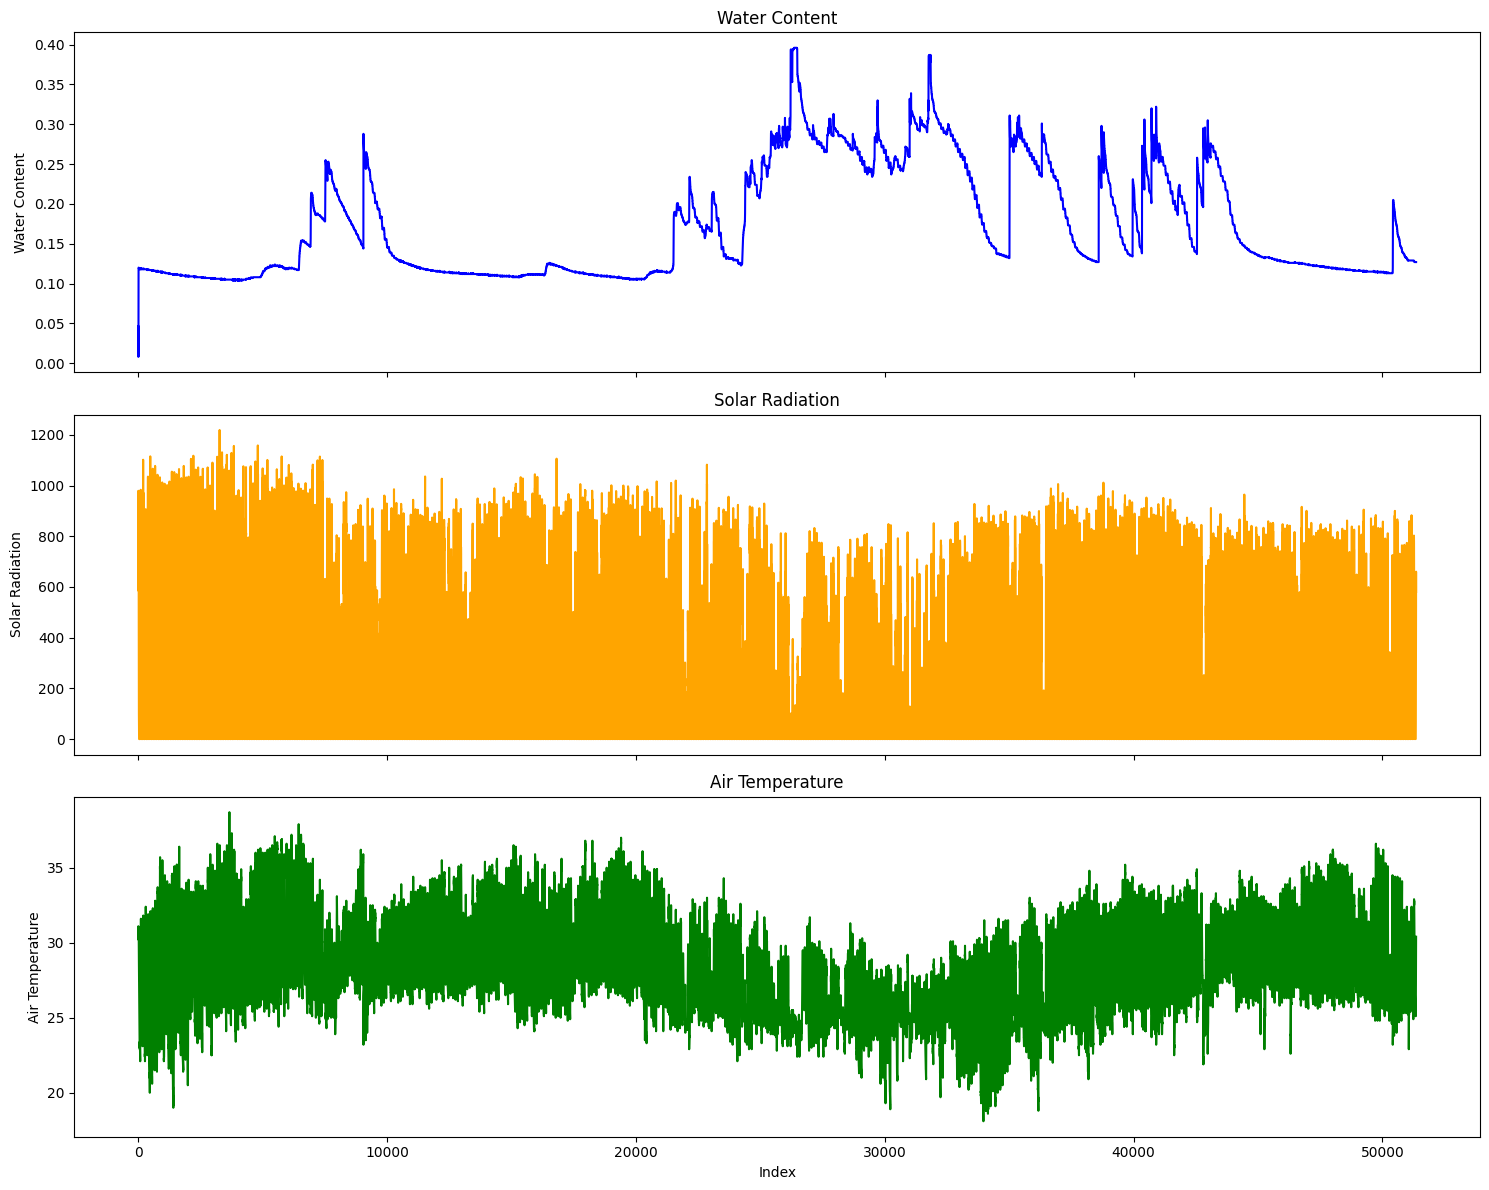

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

axs[0].plot(water_content_column, color='b')
axs[0].set_title('Water Content')
axs[0].set_ylabel('Water Content')

axs[1].plot(solar_radiation_column, color='orange')
axs[1].set_title('Solar Radiation')
axs[1].set_ylabel('Solar Radiation')

axs[2].plot(air_temperature_column, color='g')
axs[2].set_title('Air Temperature')
axs[2].set_ylabel('Air Temperature')
axs[2].set_xlabel('Index')

plt.tight_layout()
plt.show()

Plot and observe the dataset's value distribution

Completed Calculation of Water Content Histogram...
Completed Calculation of Solar Radiation Histogram...
Completed Calculation of Air Temperature Histogram...


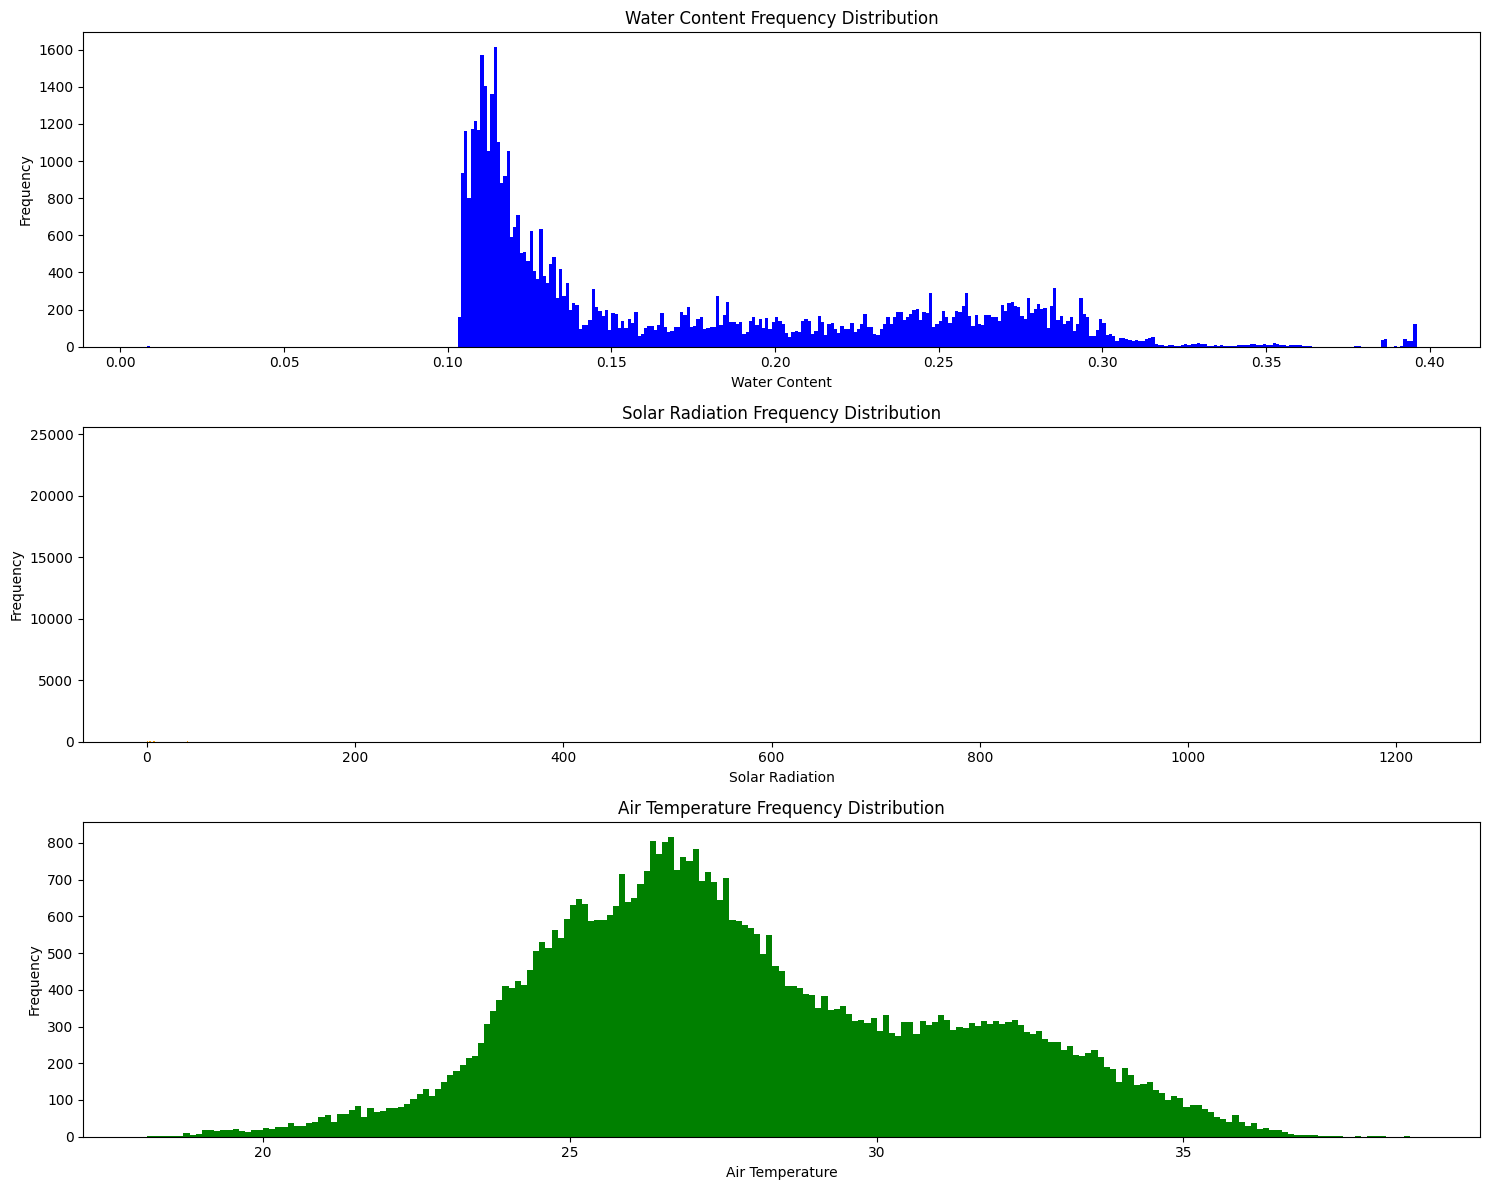

In [32]:
import numpy as np

fig, axs = plt.subplots(3, 1, figsize=(15, 12))

# Bin sizes
water_bin_size = 0.001
solar_bin_size = 0.1
air_bin_size = 0.1

# Water Content
water_min, water_max = water_content_column.min(), water_content_column.max()
water_bins = np.arange(water_min, water_max + water_bin_size, water_bin_size)
axs[0].hist(water_content_column, bins=water_bins, color='b')
axs[0].set_title('Water Content Frequency Distribution')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Water Content')

print("Completed Calculation of Water Content Histogram...")

# Solar Radiation
solar_min, solar_max = solar_radiation_column.min(), solar_radiation_column.max()
solar_bins = np.arange(solar_min, solar_max + solar_bin_size, solar_bin_size)
axs[1].hist(solar_radiation_column, bins=solar_bins, color='orange')
axs[1].set_title('Solar Radiation Frequency Distribution')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Solar Radiation')

print("Completed Calculation of Solar Radiation Histogram...")

# Air Temperature
air_min, air_max = air_temperature_column.min(), air_temperature_column.max()
air_bins = np.arange(air_min, air_max + air_bin_size, air_bin_size)
axs[2].hist(air_temperature_column, bins=air_bins, color='g')
axs[2].set_title('Air Temperature Frequency Distribution')
axs[2].set_ylabel('Frequency')
axs[2].set_xlabel('Air Temperature')

print("Completed Calculation of Air Temperature Histogram...")

plt.tight_layout()
plt.show()


Plot distribution excluding 0s given it has a relatively very high frequency of occurance compared to other values.

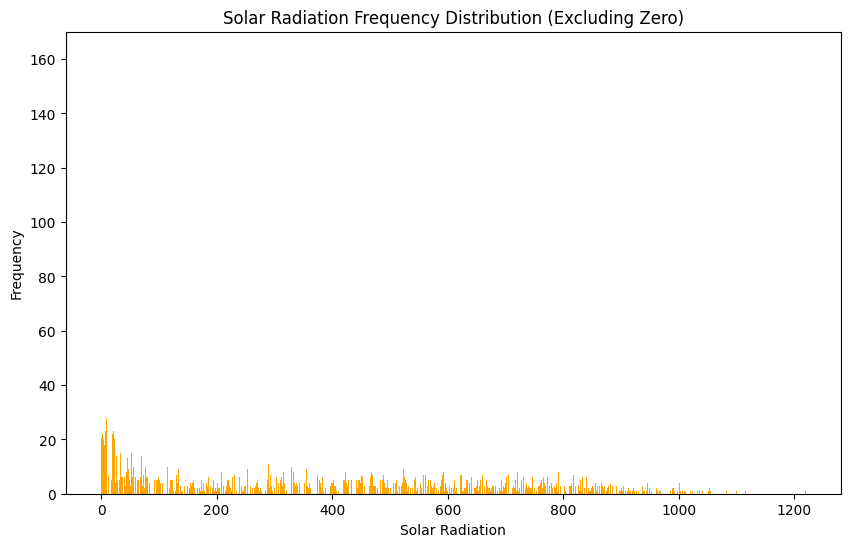

In [33]:
nonzero_solar_radiation = solar_radiation_column[solar_radiation_column != 0]

plt.figure(figsize=(10, 6))
plt.hist(nonzero_solar_radiation, bins=solar_bins, color='orange')
plt.title('Solar Radiation Frequency Distribution (Excluding Zero)')
plt.xlabel('Solar Radiation')
plt.ylabel('Frequency')
plt.show()

In [34]:
# Split training and testing sets

# Air temperature
air_temperature_training = air_temperature_column[:(len(air_temperature_column) * 9) // 10]
air_temperature_testing = air_temperature_column[(len(air_temperature_column) * 9) // 10:]

# Solar radiation
solar_radiation_training = solar_radiation_column[:(len(air_temperature_column) * 9) // 10]
solar_radiation_testing = solar_radiation_column[(len(air_temperature_column) * 9) // 10:]

# Water quality
water_quality_training = water_content_column[:(len(air_temperature_column) * 9) // 10]
water_quality_testing = water_content_column[(len(air_temperature_column) * 9) // 10:]

## Train Linear Predictor for optimum residuals

The Linear Predictor configured here outputs a single point prediction. Multiple linear regressors would be used in this case to evaluate their performance based on parameter count.

In order to train the regressor, feature and target vectors are constructed using the dataseries as follows. Given a sequential dataseries x1, x2, x3, ..., xn, a sliding window approach is used to separate features and targets as follows,

```
features = [x1, x2, x3, x4], target = x5  
features = [x2, x3, x4, x5], target = x6  
features = [x3, x4, x5, x6], target = x7  
...
```

using, 

```
Data series:   x1   x2   x3   x4   x5   x6   x7   x8 ...
Window 1:     [x1 x2 x3 x4] -> target x5
Window 2:     [x2 x3 x4 x5] -> target x6
Window 3:     [x3 x4 x5 x6] -> target x7
...
```

In general, for a window size of k:

- **Features**: [xi, xi+1, ..., xi+k-1]  
- **Target**: xi+k  

This approach allows the model to learn a mapping from a fixed number of past values (features) to the next value in the series (target). Each row in the training dataset corresponds to one such mapping, enabling the Linear Predictor to make single-step forecasts.

In [35]:
# for all datasets, make common imports
import compression_evaluation.methods as util_methods
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### For air temperature dataseries

Train linear regressors on air temperature dataset.

In [36]:
# split training dataeet into training and validating datasets
air_temperature_validating = air_temperature_training[(len(air_temperature_column) * 7) // 9:]
air_temperature_training = air_temperature_training[:(len(air_temperature_column) * 7) // 9]

In [37]:
# input dim = 5
X_train_5, y_train_5 = util_methods.build_time_series_dataset(air_temperature_training, 5, 1)
X_valid_5, y_valid_5 = util_methods.build_time_series_dataset(air_temperature_validating, 5, 1, False)

# flatten y
y_train_5 = y_train_5.ravel()
y_valid_5 = y_valid_5.ravel()

# train linear regressor
air_5_regressor = LinearRegression()
air_5_regressor.fit(X_train_5, y_train_5)

y_pred_5 = air_5_regressor.predict(X_valid_5)

# evaluate
mse = mean_squared_error(y_valid_5, y_pred_5)
print("Training MSE (5 input dim):", mse)

Training MSE (5 input dim): 0.08599423645159726


In [38]:
# input dim = 10

In [39]:
# input dim = 25

In [40]:
# input dim = 50

In [41]:
# input dim = 100

## Generate and record residuals

Using the trained predictors, residuals are generated to identify their distribution. This is done by building the complete Encoder without its Quantizer.

You might observe the residuals taking the form of laplace distributions.

### For air temperature dataseries

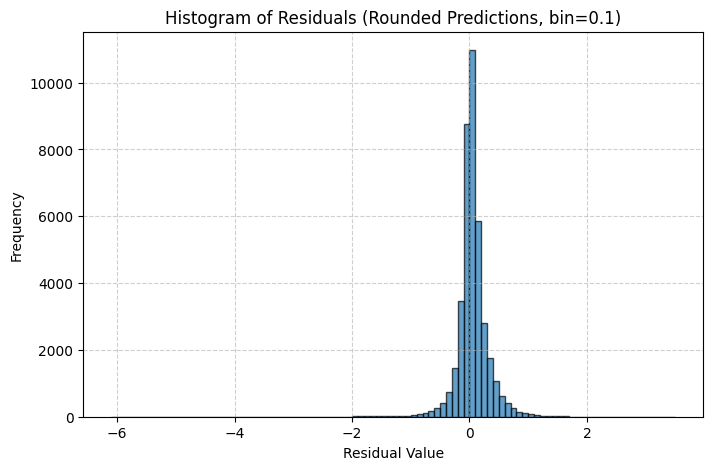

Bin centers: [-6.05 -5.95 -5.85 -5.75 -5.65 -5.55 -5.45 -5.35 -5.25 -5.15 -5.05 -4.95
 -4.85 -4.75 -4.65 -4.55 -4.45 -4.35 -4.25 -4.15 -4.05 -3.95 -3.85 -3.75
 -3.65 -3.55 -3.45 -3.35 -3.25 -3.15 -3.05 -2.95 -2.85 -2.75 -2.65 -2.55
 -2.45 -2.35 -2.25 -2.15 -2.05 -1.95 -1.85 -1.75 -1.65 -1.55 -1.45 -1.35
 -1.25 -1.15 -1.05 -0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15
 -0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05
  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95  2.05  2.15  2.25
  2.35  2.45  2.55  2.65  2.75  2.85  2.95  3.05  3.15  3.25  3.35  3.45]
Frequencies: [    0     0     0     0     0     2     0     0     0     1     0     0
     0     1     0     0     1     0     0     0     0     0     1     1
     0     0     1     1     0     1     2     2     5     1     2     2
     4     4     6     4     5    11    10    11     8     7    16    16
    24    26    28    51    69   117   172   257   420   732  1446  3469
  8771 10977  5865  2803

In [42]:
# input dim = 5
# generate predictions to all windows
y_train_pred_5 = air_5_regressor.predict(X_train_5)

# calculate residuals
# rounded to match original dataseries' quantization
res_5_train = np.round(y_train_5 - y_train_pred_5, 1)

# generate bins to fit residuals (5 bin padding on either sides)
air_5_bins = np.arange(res_5_train.min() - 5 * air_bin_size, res_5_train.max() + 5 * air_bin_size, air_bin_size)

# get counts and bin edges
air_5_counts, air_5_bin_edges = np.histogram(res_5_train, bins=air_5_bins)
air_5_bin_centers = (air_5_bin_edges[:-1] + air_5_bin_edges[1:]) / 2

# plot histogram (reusing same bins)
plt.figure(figsize=(8, 5))
plt.bar(air_5_bin_centers, air_5_counts, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals (Rounded Predictions, bin=0.1)")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# print or store for later ANS use
print("Bin centers:", air_5_bin_centers)
print("Frequencies:", air_5_counts)


In [43]:
# input dim = 10

In [44]:
# input dim = 25

In [45]:
# input dim = 50

In [46]:
# input dim = 100

## Fit frequency tables for residuals

In [47]:
# for all datasets, make common imports
from compression_evaluation.classes import UniformQuantizer, SimpleFrequencyTable

### For air temperature dataseries

In [48]:
# input_dim = 5
# pad frequencies (given ANS considers symbols with 0 occurances are impossible)
air_5_padded_counts = air_5_counts + 1

# fit quantizer
air_5_quantizer = UniformQuantizer(air_bin_size, len(air_5_bins), air_5_bin_edges[0], True)

# map bin centers to symbols
air_5_symbols = [air_5_quantizer.value_to_symbol(res) for res in air_5_bin_centers]

# display symbols and padded frequencies
print("Bin symbols:", air_5_symbols)
print("Bin count:", len(air_5_symbols))
print("Frequencies:", air_5_padded_counts)
print("Freqeuncy count:", len(air_5_padded_counts))

Bin symbols: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Bin count: 96
Frequencies: [    1     1     1     1     1     3     1     1     1     2     1     1
     1     2     1     1     2     1     1     1     1     1     2     2
     1     1     2     2     1     2     3     3     6     2     3     3
     5     5     7     5     6    12    11    12     9     8    17    17
    25    27    29    52    70   118   173   258   421   733  1447  3470
  8772 10978  5866  2804  1768  1056   624   405   260   150   102    72
    38    31    24    13    13    10     6     7     7     2     3     3
     2     2     2     2     2     1     2     2     4     1     1     1]


## Build complete encoder-decoder pair

In [49]:
from compression_evaluation.types import RegressorEnvelop
from compression_evaluation.methods import largest_remainder_quantize
from compression_evaluation.classes import ANSCoder, StaticResidualRegressor, PCEncoder, PCDecoder

### For air temperature dataseries

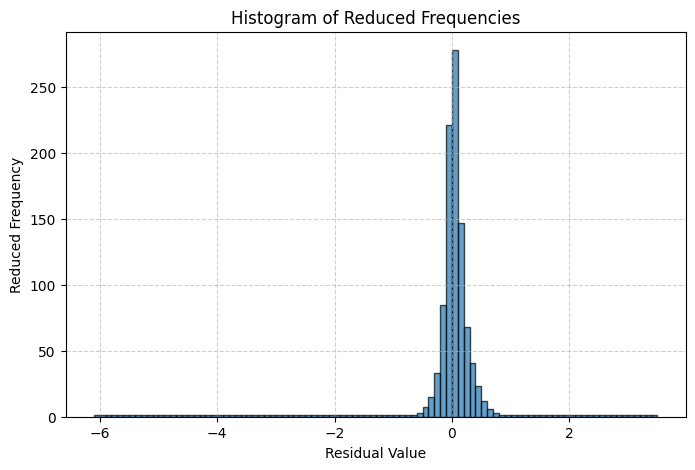

In [50]:
# input dim = 5

# trim freqencies to a total sum
air_5_counts_trimmed = largest_remainder_quantize(air_5_counts.tolist(), 1024)

# plot reduced counts to observe shape
plt.figure(figsize=(8, 5))
plt.bar(air_5_bin_centers, air_5_counts_trimmed, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Reduced Frequencies")
plt.xlabel("Residual Value")
plt.ylabel("Reduced Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# build a simple frequency table for ANS
air_5_freq_table = SimpleFrequencyTable(air_5_counts_trimmed)

# build ANS coder
air_5_ans = ANSCoder(air_5_freq_table)

# build regressor envelop for the trained linear regressor
class LinearRegressorEnvelop(RegressorEnvelop):
    def predict(self, n, input_window):
        assert n == 1, "Linear regressor can predict only one value"
        return air_5_regressor.predict(input_window.reshape(1, -1)).reshape(1)

# build static residual regressors with trained linear regressor
air_5_enveloped_regressor = LinearRegressorEnvelop()
air_5_encoder_residual_regressor = StaticResidualRegressor(air_5_enveloped_regressor, 5)
air_5_decoder_residual_regressor = StaticResidualRegressor(air_5_enveloped_regressor, 5)
# initialize sliding windows
air_5_encoder_residual_regressor._window = air_temperature_testing[0:5].to_numpy()
air_5_decoder_residual_regressor._window = air_temperature_testing[0:5].to_numpy()

# build LPC encoder and decoder
air_5_lpc_encoder = PCEncoder(air_5_encoder_residual_regressor, air_5_ans, air_5_quantizer, 1)
air_5_lpc_decoder = PCDecoder(air_5_decoder_residual_regressor, air_5_ans, air_5_quantizer, 1)

## Evaluate encoder-decoder pair

In [51]:
from compression_evaluation.evaluator import Evaluator

### For air temperature dataseries

In [52]:
# input dim = 5
# sample test
encoded = air_5_lpc_encoder.encode(air_temperature_testing[:50])
decoded = air_5_lpc_decoder.decode(encoded)
print("Original series:\t", air_temperature_testing[:50].to_list())
print("Reconstructed series:\t", np.round(np.array(decoded), 1).tolist())

air_5_evaluator = Evaluator(air_5_lpc_encoder, air_5_lpc_decoder)

# evaluate with test dataset
print("\nEvaluation Metrics:")
air_5_evaluator.evaluate(air_temperature_testing[5:].to_numpy())

Original series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]
Reconstructed series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]

Evaluation Metrics:


{'encode_time_sec': 1.8230645000003278,
 'encode_mem_mb': 483.609375,
 'decode_time_sec': 1.5884573000003002,
 'decode_mem_mb': 483.84375,
 'compression_ratio': 20.04296875,
 'bits_per_symbol': 3.193139738842331,
 'mse': np.float64(0.0008190118329635515),
 'snr_db': np.float64(60.1523150662544)}